In [ ]:
import sys
sys.path.append('../')

import time
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import utils.preprocessing
import glob
import pathlib
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch.model import UNet
from pytorch.looper import Looper
import pytorch.utils as torch_utils
from pytorch.utils import SegmentationDataset, AugmentorSegmentationDataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def display_img(img):
    fig, ax = plt.subplots(figsize=(10, 20))
    plt.imshow(img, cmap="gray")

In [2]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(
            brightness=0.5*np.random.rand(),
            contrast=0.5*np.random.rand(),
       #    saturation=0.1*np.random.rand(),
       #    hue=0.1*np.random.rand()
            ),
        transforms.PILToTensor()
    ])

In [3]:
dataset_name = "mixed_green_black_caps"
network_architecture = "unet"
ds = SegmentationDataset("../data/mixed_green_black_caps/")

In [4]:
lengths = ((int(len(ds)*0.8), int(len(ds)*0.2)) if len(ds)%2 != 0 else (int(len(ds)*0.8) + 1, int(len(ds)*0.2)))
print(lengths)
train, val = torch.utils.data.random_split(ds, lengths)

(253, 63)


In [5]:
train_loader = DataLoader(train, batch_size=8,
                        shuffle=True, num_workers=0)
valid_loader = DataLoader(val, batch_size=8,
                        shuffle=True, num_workers=0)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = UNet(input_filters=1, filters=64, N=2).to(device)
model = torch.nn.DataParallel(model)

cuda:0


In [8]:
# initialize loss, optimized and learning rate scheduler
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=20,
                                               gamma=0.1)
writer = SummaryWriter()



# create training and validation Loopers to handle a single epoch
train_looper = Looper(model, device, loss, optimizer,
                      train_loader, len(train), tensorboard_writer=writer)
valid_looper = Looper(model, device, loss, optimizer,
                      valid_loader, len(val), tensorboard_writer=writer,
                      validation=True )



In [ ]:
# current best results (lowest mean absolute error on validation set)
current_best = np.infty
es_count = 0
num_epochs = 25
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}\n")

        # run training epoch and update learning rate
        train_looper.run()
        lr_scheduler.step()

        # run validation epoch
        with torch.no_grad():
            result = valid_looper.run()
            # Early Stoping Check
            if valid_looper.running_loss[-1] >= valid_looper.running_loss[-2]:
                es_count += 1
            

        # update checkpoint if new best is reached
        if result < current_best:
            current_best = result
            torch.save(model.state_dict(),
                       f'new_trained_models/{dataset_name}_{network_architecture}.pth')
            print(f"\nNew best result: {result}")
        print("\n", "-"*80, "\n", sep='')

        if es_count > 2:
            break
print(f"[Training done] Best result: {current_best}")

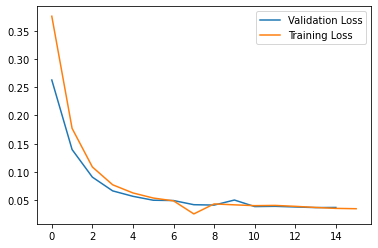

In [30]:
plt.plot(valid_looper.running_loss, label='Validation Loss')
plt.plot(train_looper.running_loss, label='Training Loss')
plt.legend()

In [25]:
model.load_state_dict(torch.load("mixed_green_black_caps_unet.pth"))
torch.save(model.state_dict(), f'new_trained_models/{dataset_name}_{network_architecture}_{time.time()}.pth')


In [21]:
errors = []
worst_cases = []
for sample in val:
    x = sample[0]
    y = sample[1]    

    prediction = model(torch.unsqueeze(x, 1)).detach().cpu().numpy()[0]
    predicted_count = torch_utils.get_count(prediction, thres=0.6)
    true_count = torch_utils.get_count(y)

    error=(torch_utils.get_count(y)-torch_utils.get_count(prediction))/torch_utils.get_count(y)
    errors.append(error * torch_utils.get_count(y))
    if error > 0.001:
        print(error)
        print(error * torch_utils.get_count(y))
        worst_cases.append((x[0], y, prediction))



0.018617021276595744
7.0


-7


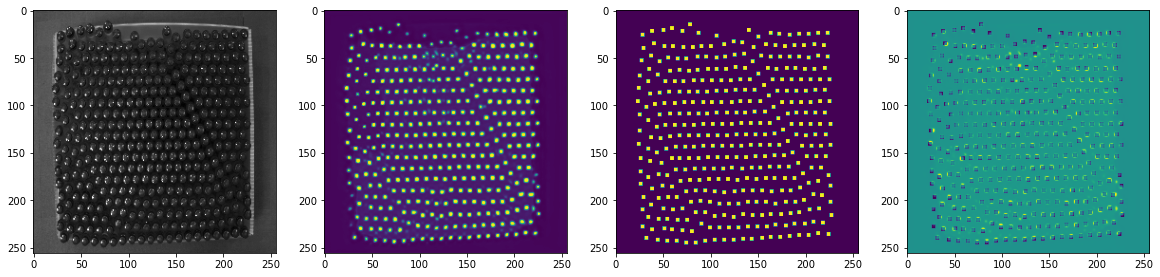

In [22]:
for case, y, prediction in worst_cases:
    print(torch_utils.get_count(prediction) - torch_utils.get_count(y) )
    plt.figure(figsize=(20, 15))
    plt.subplot(1,4,1)
    plt.imshow(case, cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(prediction[0])
    plt.subplot(1,4,3)
    plt.imshow(y[0])
    plt.subplot(1,4,4)
    plt.imshow((prediction - y.numpy())[0])    


Second column is the prediction and third colum is the labels. Fourth Column is the difference between the labels and the prediction. 1, 5 and 6 are obvious mislabelling, while 2,3,4 need to be examined.

-7


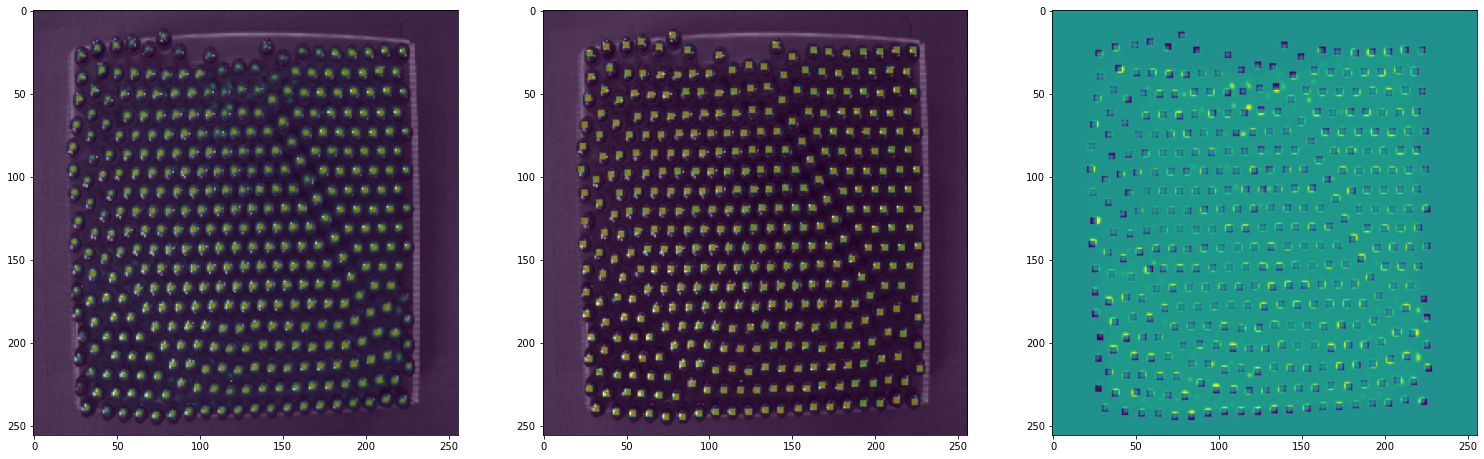

In [23]:
for case, y, prediction in worst_cases:
    print(torch_utils.get_count(prediction) - torch_utils.get_count(y) )
    plt.figure(figsize=(35, 15))
    plt.subplot(1,4,1)
    plt.imshow(case, cmap='gray')
    plt.imshow(prediction[0], alpha = 0.4)
    plt.subplot(1,4,2)
    plt.imshow(case, cmap='gray')
    plt.imshow(y[0], alpha = 0.4)
    plt.subplot(1,4,3)
    plt.imshow((prediction - y.numpy())[0]) 

In [24]:
%%timeit
prediction = model(torch.unsqueeze(x, 1)).detach().cpu().numpy()[0]

336 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
